# word2vecとは？

## 前置き

単語をベルトルに変換する手法は主に2つあります。  

- **カウントベース**  
- **推論ベース**  

このうち、**推論ベース**と呼ばれる手法が**word2vec**です。

## ポイント

単語をニューラルネットワークに入力するには、**単語をベクトルに変換**する必要があります。これがミソです。  
ここでのベクトルはone-hot表現の行列のことを言います。  
なぜ単語をベクトルに変換することがミソかと言うと、**演算可能になるから**です。  
例えば、りんごが[1, 1]、みかんが[1, 2]のベクトルで表せれるとすると、りんご[1, 1]に重み[0, 1]を足し算すれば、  
みかん[1, 2]を得ることができます。この例は極端かもしれませんが、  
**単語をベクトルに変換し、演算可能にする**ことで推論を可能にしているのです。

## word2vecのモデルは？

### C-BOW（continuous bag-of-words）

簡単に言うと、ターゲット（予測したい単語）を周囲のコンテキストから予測する手法のことです。  
例えば、**You ○○○ goodbye, I say hello.**というテキストデータが与えられた時、  
○○○の周囲の単語（You, goodbye）から○○○に入る単語を予測させることがC-BOWの手法になります。  
テキストデータをニューラルネットワークの入力データとして使用し、出力として当てはまる単語の確率を出します。  
よって、ニューラルネットワークに入力するデータはターゲットの周囲にあるコンテキストになります。

### skip-gram

簡単に言うと、ある単語から周囲のコンテキスト（ターゲットとなる複数の単語）を予測する手法のことです。  
例えば、○○○ say ○○○, I say hello.というテキストデータが与えられた時、  
sayから周囲の単語（○○○、○○○）に入る単語を予測させることがskip-gramの手法です。  
よって、ニューラルネットワークに入力するデータはターゲットの間にある単語になります。  
前述したC-BOWと全く逆のアプローチです。

# C-BOW

## 実装

In [1]:
import numpy as np

In [84]:
def preprocess(text):
    text = text.lower()
    words = text.replace('.', ' .').split(' ')
    
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [85]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

In [86]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [87]:
def one_hot(corpus):
    return np.identity(len(np.unique(corpus)))[corpus]

In [88]:
corpus = one_hot(corpus)

In [89]:
corpus

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [144]:
def create_contexts_target(corpus, window_size=1):
    
    corpus = one_hot(corpus)
    
    contexts = []
    target = corpus[window_size:-window_size]
    
    for idx in range(window_size, len(corpus)-window_size):
        context = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            context.append(corpus[idx + t])
        contexts.append(context)

    return np.array(contexts), np.array(target)

In [91]:
contexts, target = create_contexts_target(corpus)

In [92]:
print(contexts.shape)
contexts

(6, 2, 7)


array([[[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]],

       [[0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]],

       [[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.]]])

In [93]:
print(target.shape)
target

(6, 7)


array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]])

In [94]:
contexts.shape

(6, 2, 7)

In [37]:
def forward_loss(output):
    exp_out = np.exp(output + 1e-08)
    exp_out_sum = np.sum(np.exp(output + 1e-08))
    softmax =  exp_out / exp_out_sum
    return -np.sum(np.log(softmax) * target) 

In [38]:
def forward(contexts, target):
    hidden_size = contexts.shape[1] + 1
    w_in = np.random.randn(contexts.shape[2], hidden_size)
    w_out = np.random.randn(hidden_size, contexts.shape[2])

    cross_entropy = []
    for context in contexts:
        context_dot = []
        for word in context:
            word = word.reshape(1, word.shape[0])
            h = np.dot(word, w_in)
            context_dot.append(h)
        h_sum = np.sum(np.array(context_dot), axis=0)
        h_out = np.dot(h_sum, w_out)
        
        loss = forward_loss(h_out)
        cross_entropy.append(loss)
        
    return np.sum(np.array(cross_entropy))

In [39]:
forward = forward(contexts, target)

In [40]:
forward

922951.3155415655

ここで自分のコードではbackwardができないことが判明したので、教科書を参考にクラス化を学んで実装したいと思います。

In [156]:
def preprocess(text):
    text = text.lower()
    words = text.replace('.', ' .').split(' ')
    
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [158]:
def convert_one_hot(corpus, vocab_size):
    '''one-hot表現への変換
    :param corpus: 単語IDのリスト（1次元もしくは2次元のNumPy配列）
    :param vocab_size: 語彙数
    :return: one-hot表現（2次元もしくは3次元のNumPy配列）
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [157]:
def create_contexts_target(corpus, window_size=1):
    contexts = []
    target = corpus[window_size:-window_size]
    
    for idx in range(window_size, len(corpus)-window_size):
        context = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            context.append(corpus[idx + t])
        contexts.append(context)

    return np.array(contexts), np.array(target)

In [140]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
        
    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out
        
    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dw = np.dot(self.x.T, dout)
        self.grads[0][...] = dw
        return dx

In [141]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [142]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

In [143]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

In [146]:
class SGD:
    '''
    確率的勾配降下法（Stochastic Gradient Descent）
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]


class Momentum:
    '''
    Momentum SGD
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] = self.momentum * self.v[i] - self.lr * grads[i]
            params[i] += self.v[i]


class Nesterov:
    '''
    Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] *= self.momentum
            self.v[i] -= self.lr * grads[i]
            params[i] += self.momentum * self.momentum * self.v[i]
            params[i] -= (1 + self.momentum) * self.lr * grads[i]


class AdaGrad:
    '''
    AdaGrad
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] += grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class RMSprop:
    '''
    RMSprop
    '''
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] *= self.decay_rate
            self.h[i] += (1 - self.decay_rate) * grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

In [163]:
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()

In [166]:
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

In [168]:
def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [164]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 277 |  iter 1 / 2 | time 0[s] | loss 1.01
| epoch 278 |  iter 1 / 2 | time 0[s] | loss 0.97
| epoch 279 |  iter 1 / 2 | time 0[s] | loss 0.97
| epoch 280 |  iter 1 / 2 | time 0[s] | loss 0.87
| epoch 281 |  iter 1 / 2 | time 0[s] | loss 1.03
| epoch 282 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 283 |  iter 1 / 2 | time 0[s] | loss 0.96
| epoch 284 |  iter 1 / 2 | time 0[s] | loss 0.95
| epoch 285 |  iter 1 / 2 | time 0[s] | loss 0.86
| epoch 286 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 287 |  iter 1 / 2 | time 0[s] | loss 0.84
| epoch 288 |  iter 1 / 2 | time 0[s] | loss 1.02
| epoch 289 |  iter 1 / 2 | time 0[s] | loss 0.97
| epoch 290 |  iter 1 / 2 | time 0[s] | loss 0.91
| epoch 291 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 292 |  iter 1 / 2 | time 0[s] | loss 0.94
| epoch 293 |  iter 1 / 2 | time 0[s] | loss 0.97
| epoch 294 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 295 |  iter 1 / 2 | time 0[s] | loss 0.94
| epoch 296 |  iter 1 / 2 | time 0[s] | loss 0.86


| epoch 552 |  iter 1 / 2 | time 0[s] | loss 0.57
| epoch 553 |  iter 1 / 2 | time 0[s] | loss 0.63
| epoch 554 |  iter 1 / 2 | time 0[s] | loss 0.76
| epoch 555 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 556 |  iter 1 / 2 | time 0[s] | loss 0.56
| epoch 557 |  iter 1 / 2 | time 0[s] | loss 0.63
| epoch 558 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 559 |  iter 1 / 2 | time 0[s] | loss 0.50
| epoch 560 |  iter 1 / 2 | time 0[s] | loss 0.72
| epoch 561 |  iter 1 / 2 | time 0[s] | loss 0.50
| epoch 562 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 563 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 564 |  iter 1 / 2 | time 0[s] | loss 0.66
| epoch 565 |  iter 1 / 2 | time 0[s] | loss 0.52
| epoch 566 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 567 |  iter 1 / 2 | time 0[s] | loss 0.56
| epoch 568 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 569 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 570 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 571 |  iter 1 / 2 | time 0[s] | loss 0.62


| epoch 835 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 836 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 837 |  iter 1 / 2 | time 0[s] | loss 0.44
| epoch 838 |  iter 1 / 2 | time 0[s] | loss 0.54
| epoch 839 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 840 |  iter 1 / 2 | time 0[s] | loss 0.47
| epoch 841 |  iter 1 / 2 | time 0[s] | loss 0.49
| epoch 842 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 843 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 844 |  iter 1 / 2 | time 0[s] | loss 0.49
| epoch 845 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 846 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 847 |  iter 1 / 2 | time 0[s] | loss 0.42
| epoch 848 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 849 |  iter 1 / 2 | time 0[s] | loss 0.37
| epoch 850 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 851 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 852 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 853 |  iter 1 / 2 | time 0[s] | loss 0.42
| epoch 854 |  iter 1 / 2 | time 0[s] | loss 0.64


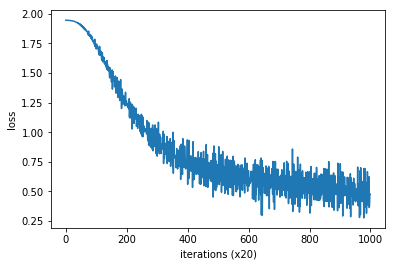

you [-1.2698123  1.5256764  0.8645232 -0.8957373 -0.955038 ]
say [ 2.7087075e-01 -8.5974060e-04 -1.3009163e+00  3.6405998e-01
  1.3159113e+00]
goodbye [-0.5457958   0.19701713  1.0009705  -1.2155739  -0.91347367]
and [-1.5644999  1.4393291 -1.1126041  1.3763032  1.1397157]
i [-0.5590153   0.19093888  1.0154027  -1.2183925  -0.8995232 ]
hello [-1.2717025   1.5155798   0.87362933 -0.8814404  -0.94952446]
. [ 1.238087  -1.2315363 -1.1044625 -1.3987166  1.1041391]


In [169]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

# skip-gram

## 実装

In [170]:
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 3.88
| epoch 21 |  iter 1 / 2 | ti

| epoch 237 |  iter 1 / 2 | time 0[s] | loss 2.55
| epoch 238 |  iter 1 / 2 | time 0[s] | loss 2.67
| epoch 239 |  iter 1 / 2 | time 0[s] | loss 2.61
| epoch 240 |  iter 1 / 2 | time 0[s] | loss 2.61
| epoch 241 |  iter 1 / 2 | time 0[s] | loss 2.59
| epoch 242 |  iter 1 / 2 | time 0[s] | loss 2.53
| epoch 243 |  iter 1 / 2 | time 0[s] | loss 2.53
| epoch 244 |  iter 1 / 2 | time 0[s] | loss 2.73
| epoch 245 |  iter 1 / 2 | time 0[s] | loss 2.52
| epoch 246 |  iter 1 / 2 | time 0[s] | loss 2.45
| epoch 247 |  iter 1 / 2 | time 0[s] | loss 2.74
| epoch 248 |  iter 1 / 2 | time 0[s] | loss 2.43
| epoch 249 |  iter 1 / 2 | time 0[s] | loss 2.58
| epoch 250 |  iter 1 / 2 | time 0[s] | loss 2.72
| epoch 251 |  iter 1 / 2 | time 0[s] | loss 2.65
| epoch 252 |  iter 1 / 2 | time 0[s] | loss 2.50
| epoch 253 |  iter 1 / 2 | time 0[s] | loss 2.66
| epoch 254 |  iter 1 / 2 | time 0[s] | loss 2.55
| epoch 255 |  iter 1 / 2 | time 0[s] | loss 2.43
| epoch 256 |  iter 1 / 2 | time 0[s] | loss 2.62


| epoch 451 |  iter 1 / 2 | time 0[s] | loss 2.56
| epoch 452 |  iter 1 / 2 | time 0[s] | loss 2.37
| epoch 453 |  iter 1 / 2 | time 0[s] | loss 2.17
| epoch 454 |  iter 1 / 2 | time 0[s] | loss 2.37
| epoch 455 |  iter 1 / 2 | time 0[s] | loss 2.51
| epoch 456 |  iter 1 / 2 | time 0[s] | loss 2.28
| epoch 457 |  iter 1 / 2 | time 0[s] | loss 2.17
| epoch 458 |  iter 1 / 2 | time 0[s] | loss 2.51
| epoch 459 |  iter 1 / 2 | time 0[s] | loss 2.36
| epoch 460 |  iter 1 / 2 | time 0[s] | loss 2.51
| epoch 461 |  iter 1 / 2 | time 0[s] | loss 2.42
| epoch 462 |  iter 1 / 2 | time 0[s] | loss 2.37
| epoch 463 |  iter 1 / 2 | time 0[s] | loss 2.31
| epoch 464 |  iter 1 / 2 | time 0[s] | loss 2.27
| epoch 465 |  iter 1 / 2 | time 0[s] | loss 2.51
| epoch 466 |  iter 1 / 2 | time 0[s] | loss 2.16
| epoch 467 |  iter 1 / 2 | time 0[s] | loss 2.51
| epoch 468 |  iter 1 / 2 | time 0[s] | loss 2.56
| epoch 469 |  iter 1 / 2 | time 0[s] | loss 2.36
| epoch 470 |  iter 1 / 2 | time 0[s] | loss 2.21


| epoch 690 |  iter 1 / 2 | time 0[s] | loss 2.02
| epoch 691 |  iter 1 / 2 | time 0[s] | loss 2.14
| epoch 692 |  iter 1 / 2 | time 0[s] | loss 2.16
| epoch 693 |  iter 1 / 2 | time 0[s] | loss 2.65
| epoch 694 |  iter 1 / 2 | time 0[s] | loss 1.91
| epoch 695 |  iter 1 / 2 | time 0[s] | loss 2.34
| epoch 696 |  iter 1 / 2 | time 0[s] | loss 2.13
| epoch 697 |  iter 1 / 2 | time 0[s] | loss 2.42
| epoch 698 |  iter 1 / 2 | time 0[s] | loss 2.15
| epoch 699 |  iter 1 / 2 | time 0[s] | loss 2.36
| epoch 700 |  iter 1 / 2 | time 0[s] | loss 2.20
| epoch 701 |  iter 1 / 2 | time 0[s] | loss 1.92
| epoch 702 |  iter 1 / 2 | time 0[s] | loss 2.55
| epoch 703 |  iter 1 / 2 | time 0[s] | loss 1.96
| epoch 704 |  iter 1 / 2 | time 0[s] | loss 2.23
| epoch 705 |  iter 1 / 2 | time 0[s] | loss 2.28
| epoch 706 |  iter 1 / 2 | time 0[s] | loss 2.23
| epoch 707 |  iter 1 / 2 | time 0[s] | loss 2.14
| epoch 708 |  iter 1 / 2 | time 0[s] | loss 2.36
| epoch 709 |  iter 1 / 2 | time 0[s] | loss 2.14


| epoch 933 |  iter 1 / 2 | time 0[s] | loss 1.55
| epoch 934 |  iter 1 / 2 | time 0[s] | loss 2.26
| epoch 935 |  iter 1 / 2 | time 0[s] | loss 2.25
| epoch 936 |  iter 1 / 2 | time 0[s] | loss 1.82
| epoch 937 |  iter 1 / 2 | time 0[s] | loss 2.05
| epoch 938 |  iter 1 / 2 | time 0[s] | loss 1.82
| epoch 939 |  iter 1 / 2 | time 0[s] | loss 2.03
| epoch 940 |  iter 1 / 2 | time 0[s] | loss 2.23
| epoch 941 |  iter 1 / 2 | time 0[s] | loss 2.03
| epoch 942 |  iter 1 / 2 | time 0[s] | loss 2.03
| epoch 943 |  iter 1 / 2 | time 0[s] | loss 2.03
| epoch 944 |  iter 1 / 2 | time 0[s] | loss 2.04
| epoch 945 |  iter 1 / 2 | time 0[s] | loss 1.79
| epoch 946 |  iter 1 / 2 | time 0[s] | loss 2.27
| epoch 947 |  iter 1 / 2 | time 0[s] | loss 1.98
| epoch 948 |  iter 1 / 2 | time 0[s] | loss 2.05
| epoch 949 |  iter 1 / 2 | time 0[s] | loss 2.00
| epoch 950 |  iter 1 / 2 | time 0[s] | loss 2.07
| epoch 951 |  iter 1 / 2 | time 0[s] | loss 2.01
| epoch 952 |  iter 1 / 2 | time 0[s] | loss 2.24


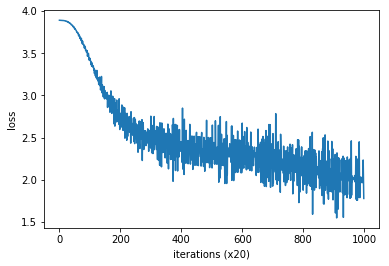

you [-0.0013573  -0.01566786 -0.00747191 -0.00026809 -0.0072482 ]
say [-0.74841666  0.31158152 -0.16234937  0.88289195 -0.14676164]
goodbye [ 0.8996863  -0.8540542   0.5818055  -0.96019655  1.1078326 ]
and [-1.043036    1.1849048  -1.248922    0.97672766 -1.2063864 ]
i [ 0.9009406  -0.84542984  0.58955985 -0.97231513  1.1115576 ]
hello [ 0.48380503 -0.7830277   1.4092441  -0.10014728 -0.51874524]
. [ 0.01778921 -0.00894656  0.01011797 -0.0024142  -0.00161137]


In [171]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

# word2vecの改良

## Embedding

### 説明

入力データはone-hotをかけた行列になるため、単語数が多くなるにつれ、計算量が異常に増えます。  
隠れ層の計算は対象の単語のベクトルを抽出することでしたが、これまで実装したやり方だと、  
その他の関係ない単語のベクトルを計算対象と入れてしまっているため、計算コストが非常に大きいです。  
そのため、Embeddingを用いて、巨大な行列の計算対象となる部分のみ抽出し、演算を行うように改良します。

### 実装

In [172]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

In [173]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

## Negative sampling

### 説明

これまでは多値分類としてSoftmax関数を使ってcross entropyを計算していましたが、  
それを二値分類として扱い、Sigmoid関数を用いて計算コストを削減する方法をとります。  
また、これまでは計算対象でないベクトルまでSoftmax関数にかけていましたが、  
Embeddingを用いて、計算対象となるベクトルのみをSigmoid関数にかけていきます。  

しかし、これだけでは正しい単語しか学習できません。  
つまり、具体的にどんなベクトルが正しいもので、どんなベクトルが間違っているかまでは学習ができていないということです。  
そのため、間違っているベクトルも学習をさせるというのがNegative samplingの考え方です。  
しかし、間違っているベクトルは無数にあるので、全てを学習させるのは現実的でないので、  
少数の間違いベクトルを学習させ、正しいベクトルと間違っているベクトルの両方を学習させ、その損失を得ることが目標となります。  
少数の間違いベクトルをサンプリングすることをNegative samplingと言います。

Negative samplingはランダムでサンプリングするのではなく、コーパスの統計データに基づいてサンプリングを行います。  
つまり、コーパスの中でよく使われる単語はサンプリングされやすく、あまり使われない単語はサンプリングされにくくするということです。  
具体的には、コーパスの中で出てくる単語の出現回数をカウントし、確率分布を作成して、そこからサンプリングします。  

### 実装

In [138]:
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.p_words = None
        self.vocab_size = None

        count_word = {}
        for i in range(len(corpus)):
            if str(corpus[i]) not in count_word:
                count_word[str(corpus[i])] = 1
            else:
                count_word[str(corpus[i])] += 1

        self.p_words = np.array(list(count_word.values()))
        self.p_words = np.power(self.p_words, power)
        self.p_words /= np.sum(self.p_words)
        self.vocab_size = len(self.p_words)
        
    def get_negative_sample(self, target):
        batch_size = target.shape[0]
        
        negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size), replace=True, p=self.p_words)
        
        return negative_sample.astype(np.float32)

In [174]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 正例のフォワード
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 負例のフォワード
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

## C-BOW

In [179]:
class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoidの出力
        self.t = None  # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx

In [175]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # レイヤの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embeddingレイヤを使用
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # すべての重みと勾配をリストにまとめる
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

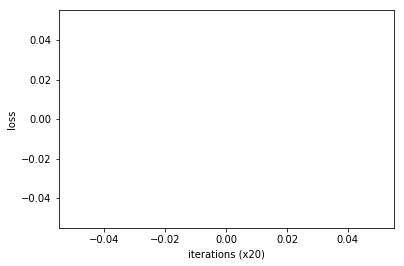

you [ 7.61623075e-03 -1.01778712e-02 -1.81947928e-02 -2.56439522e-02
  6.78187888e-03 -1.20585682e-02  5.98020758e-03 -3.05192824e-03
  1.97508046e-03 -4.25651763e-03  7.59745250e-04  3.64944059e-03
  1.34436255e-02  4.32967907e-03  1.12647181e-02  3.04874266e-03
  9.08672344e-03 -1.45734346e-04  4.42581018e-04  5.96894743e-03
  1.08260347e-03 -9.65679251e-03  9.44333989e-03 -8.20281915e-03
 -1.65324230e-02  2.20384391e-04 -1.65524916e-03 -8.81678949e-04
  1.02758752e-02 -1.76570611e-04 -1.39348675e-02 -2.54139863e-03
  3.35517759e-03  5.10660745e-03  6.28644461e-03  1.73175998e-03
 -8.88302922e-03 -1.15810568e-02 -5.88219799e-03  1.69534830e-03
 -1.76912230e-02 -1.49325859e-02 -1.56594941e-03 -6.35767792e-05
  1.50509132e-03 -4.57486650e-03  9.84647032e-03 -7.72605091e-03
  6.76560448e-03  1.37694203e-03 -1.08100893e-03 -2.79528531e-03
 -9.35335178e-03 -4.76405863e-03 -1.20421201e-02  1.80754272e-04
  8.13921168e-03  1.76703148e-02 -1.75875588e-03  7.69502344e-03
 -9.26292210e-04 -4.4

In [183]:
# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# データの読み込み
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
# if config.GPU:
#     contexts, target = to_gpu(contexts), to_gpu(target)

# モデルなどの生成
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 学習開始
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs
# if config.GPU:
#     word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
# pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
# with open(pkl_file, 'wb') as f:
#     pickle.dump(params, f, -1)

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])